In [10]:
## Import Dependencies

from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import datetime as dt
import time
import seaborn as sns
import numpy as np
import scipy.stats as stats

In [11]:
#Read in the power data for DP&L
df = pd.read_csv('DPL_Hourly_Consumption.csv',parse_dates =['Datetime'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121275 entries, 0 to 121274
Data columns (total 2 columns):
Datetime     121275 non-null datetime64[ns]
DAYTON_MW    121275 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.9 MB


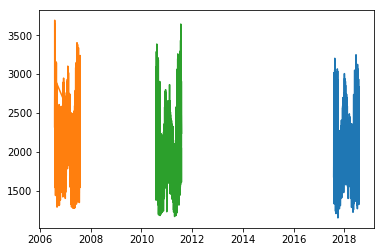

In [13]:
## some simple plots to visualize the data

x = df[(df.Datetime> "2017-08-01") & (df.Datetime <= '2018-08-01')].Datetime
y = df[(df.Datetime> "2017-08-01") & (df.Datetime <= '2018-08-01')].DAYTON_MW
x2 = df[(df.Datetime> "2006-08-01") & (df.Datetime <= '2007-08-01')].Datetime
y2 = df[(df.Datetime> "2006-08-01") & (df.Datetime <= '2007-08-01')].DAYTON_MW
x3 = df[(df.Datetime> "2010-08-01") & (df.Datetime <= '2011-08-01')].Datetime
y3 = df[(df.Datetime> "2010-08-01") & (df.Datetime <= '2011-08-01')].DAYTON_MW
plt.plot(x,y)
plt.plot(x2,y2)
plt.plot(x3,y3)

plt.show()



In [14]:
# Read in Weather Data

Wd = pd.read_json("weather_data_json_dayton_bulkText.json")

In [15]:
Wd.head()
Wd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42169 entries, 0 to 42168
Data columns (total 9 columns):
city_id    42169 non-null int64
clouds     42169 non-null object
dt         42169 non-null int64
dt_iso     42169 non-null object
main       42169 non-null object
rain       6327 non-null object
snow       46 non-null object
weather    42169 non-null object
wind       42169 non-null object
dtypes: int64(2), object(7)
memory usage: 2.9+ MB


In [16]:
## Cleaner way to pull this in as datetime.. create column and use the lambda to get rid of the extra UTC datetime data
Wd['Date_Clean'] = (Wd['dt_iso'].apply(lambda x: x[:19])
                    .apply(lambda x : dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
                   )

In [17]:
# because we are going to make use of the dates in our analysis .. rows for month year, day, day of week, and weekend are created. 

Wd2 = Wd.assign(year = Wd['Date_Clean'].dt.year,
         month = Wd['Date_Clean'].dt.month,
         day = Wd['Date_Clean'].dt.day,
         day_of_week = Wd['Date_Clean'].dt.weekday,
         weekend = Wd['Date_Clean'].dt.weekday.apply(lambda x : 1 if x > 4 else 0)).copy()
Wd2.head()

,city_id,clouds,dt,dt_iso,main,rain,snow,weather,wind,Date_Clean,year,month,day,day_of_week,weekend
0,4509884,{'all': 75},1349096400,2012-10-01 13:00:00 +0000 UTC,"{'temp': 284.02, 'temp_min': 282.15, 'temp_max...",NaN,NaN,"[{'id': 803, 'main': 'Clouds', 'description': ...","{'speed': 2, 'deg': 30}",2012-10-01 13:00:00,2012,10,1,0,0
1,4509884,{'all': 75},1349100000,2012-10-01 14:00:00 +0000 UTC,"{'temp': 285.83, 'temp_min': 284.26, 'temp_max...",NaN,NaN,"[{'id': 803, 'main': 'Clouds', 'description': ...","{'speed': 2, 'deg': 50}",2012-10-01 14:00:00,2012,10,1,0,0
2,4509884,{'all': 75},1349190000,2012-10-02 15:00:00 +0000 UTC,"{'temp': 287.44, 'temp_min': 286.48, 'temp_max...",NaN,NaN,"[{'id': 803, 'main': 'Clouds', 'description': ...","{'speed': 3, 'deg': 90}",2012-10-02 15:00:00,2012,10,2,1,0
3,4509884,{'all': 1},1349193600,2012-10-02 16:00:00 +0000 UTC,"{'temp': 288.31, 'temp_min': 287.15, 'temp_max...",NaN,NaN,"[{'id': 800, 'main': 'Clear', 'description': '...","{'speed': 3, 'deg': 70}",2012-10-02 16:00:00,2012,10,2,1,0
4,4509884,{'all': 40},1349197200,2012-10-02 17:00:00 +0000 UTC,"{'temp': 289.5, 'temp_min': 288.71, 'temp_max'...",NaN,NaN,"[{'id': 802, 'main': 'Clouds', 'description': ...","{'speed': 4, 'deg': 80}",2012-10-02 17:00:00,2012,10,2,1,0


In [18]:
# We have some conversions to do as some of the columns are dicts, and units are not suitable

Temp = []
Humidity = []
Wind = []
Date_Time = []
Rain = []
Month = []
Snow = []
Year = []
Day = []
Day_of_Week = []
Weekend = []

for i in range(0,len(Wd2)):
    #Convert to Fahrenheit
    t = round(((Wd2.main[i]['temp_max']-273.15)*9/5)+32,2)
    h = Wd2.main[i]['humidity']
    #Convert to MPH
    w = round(Wd2.wind[i]['speed']*2.26394,2)
    d = Wd2['Date_Clean'][i]
    r = Wd2.rain[i]
    s = Wd2.snow[i]
    m = Wd2.month[i]
    y = Wd2.year[i]
    dy = Wd2.day[i]
    dow =Wd2.day_of_week[i]
    wknd = Wd2.weekend[i]
    Rain.append(r)
    Snow.append(s)
    Date_Time.append(d)
    Wind.append(w)
    Humidity.append(h)
    Temp.append(t)
    Month.append(m)
    Year.append(y)
    Day.append(dy)
    Day_of_Week.append(dow)
    Weekend.append(wknd)

    
# now we have a group of lists 


In [19]:
#Next build dictionary to reassemble our DF
Wd_dict = {'City':"Dayton,OH",'Datetime':Date_Time,"Year":Year,'Month':Month,'Day':Day,'Day_of_Week':Day_of_Week,'Weekend':Weekend,'Temperature(F)':Temp,
          'Humidity':Humidity,'Wind Speed(mph)':Wind,'Rain Volume':Rain,'Snow Volume':Snow,}
Wd_df = pd.DataFrame(Wd_dict)

In [20]:
Wd_df.head()


,City,Datetime,Year,Month,Day,Day_of_Week,Weekend,Temperature(F),Humidity,Wind Speed(mph),Rain Volume,Snow Volume
0,"Dayton,OH",2012-10-01 13:00:00,2012,10,1,0,0,54.00,81,4.53,NaN,NaN
1,"Dayton,OH",2012-10-01 14:00:00,2012,10,1,0,0,57.99,76,4.53,NaN,NaN
2,"Dayton,OH",2012-10-02 15:00:00,2012,10,2,1,0,59.00,62,6.79,NaN,NaN
3,"Dayton,OH",2012-10-02 16:00:00,2012,10,2,1,0,62.01,77,6.79,NaN,NaN
4,"Dayton,OH",2012-10-02 17:00:00,2012,10,2,1,0,63.00,72,9.06,NaN,NaN


In [21]:
## calling info we confirm we have a datetime object for Datetime
Wd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42169 entries, 0 to 42168
Data columns (total 12 columns):
City               42169 non-null object
Datetime           42169 non-null datetime64[ns]
Year               42169 non-null int64
Month              42169 non-null int64
Day                42169 non-null int64
Day_of_Week        42169 non-null int64
Weekend            42169 non-null int64
Temperature(F)     42169 non-null float64
Humidity           42169 non-null int64
Wind Speed(mph)    42169 non-null float64
Rain Volume        6327 non-null object
Snow Volume        46 non-null object
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 3.9+ MB


In [22]:
## ok now ready we agreed to use more recent data for our dataset 
# so will grab data from May1 of 2016 thru April 30 2018.
df.Datetime.head(24)

df_2 = df[(df.Datetime>='2016-05-01 00:00:00') & (df.Datetime< '2018-05-01 00:00:00')].copy()
df_2.set_index('Datetime',inplace = True)




In [23]:
daily_average = df_2.resample('D').mean()

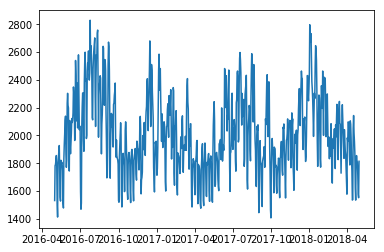

In [24]:

plt.plot(daily_average)



In [25]:
monthly_average = df_2.resample('M').mean()

In [26]:
monthly_average

,DAYTON_MW
Datetime,
2016-05-31,1788.401882
2016-06-30,2150.641667
2016-07-31,2269.213710
2016-08-31,2401.627688
2016-09-30,2082.198611
2016-10-31,1788.114247
2016-11-30,1838.656033
2016-12-31,2130.098118
2017-01-31,2089.561828


In [34]:
monthly_average['month_abr'] = monthly_average.index.strftime("%m%y")
#year_2016 = monthly_average.loc[:'2016-05-01' 2016-,:]

In [32]:
monthly_average


,DAYTON_MW,month_abr
Datetime,,
2016-05-31,1788.401882,0516
2016-06-30,2150.641667,0616
2016-07-31,2269.213710,0716
2016-08-31,2401.627688,0816
2016-09-30,2082.198611,0916
2016-10-31,1788.114247,1016
2016-11-30,1838.656033,1116
2016-12-31,2130.098118,1216
2017-01-31,2089.561828,0117


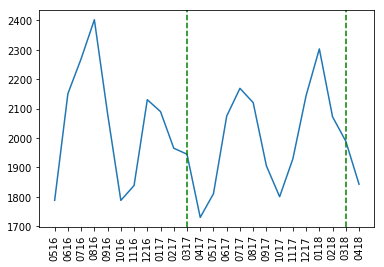

In [38]:

daily_average_plot= plt.plot(monthly_average['month_abr'], monthly_average['DAYTON_MW'])
#vertical line
#plt.axvline(dt.datetime(2017,3,12))
plt.xticks(rotation=90)

plt.axvline(x='0317', color='g', linestyle= '--')
plt.axvline(x='0318',color='g', linestyle= '--')
#label legend here
#write legend to define green line



In [ ]:
## lets take a look at the len
len(df_2)


In [ ]:
## so the Weather Df we create should be of the same length

Wd_df_2 = Wd_df[(Wd_df.Datetime>='2016-05-01 00:00:00') & (Wd_df.Datetime< '2018-05-01 00:00:00')].copy()
Wd_df_2.set_index('Datetime',inplace = True)
Wd_df_2.head()

In [ ]:
### so it seems we have some missing values in the weather data this will mean some times 76 hours where we will not get a 
## match on the join.

combined_df = df_2.join(Wd_df_2,how = 'left')
combined_df.drop(index = combined_df[combined_df.City.isna()].index.values,inplace = True)


In [ ]:
combined_df.info()

In [ ]:
y= combined_df[(combined_df["Temperature(F)"]> 60)&(combined_df.Year == 2016) & (combined_df.Month==6)]['Temperature(F)']
x= combined_df[(combined_df["Temperature(F)"]>60)&(combined_df.Year == 2016) & (combined_df.Month==6)]['DAYTON_MW']
x2 =combined_df.iloc[150:]['Humidity']
plt.scatter(x,y)

plt.show()
 = np.cov(x.values,y.values)[0,1]
#x.values


In [ ]:

First_Week_df = combined_df[(combined_df.index >= '2016-07-01') & (combined_df.index < '2016-07-02')]
June = combined_df
FWmean = round(First_Week_df['Temperature(F)'].mean(),2)
FWstd = round(First_Week_df["Temperature(F)"].std(),2)
FWsem = round(First_Week_df["Temperature(F)"].sem(),2)
FWsem
First_Week_df['DAYTON_MW'].mean()
First_Week_df.info()

In [ ]:
plt.figure(figsize=[14,7])


x = First_Week_df.index   #['Temperature(F)']
y = First_Week_df["DAYTON_MW"]
y2 = First_Week_df['Temperature(F)']*25
#plt.xlim("2016-05-01","2016-05-08")
plt.plot(x,y)
plt.plot(x,y2)



In [ ]:
First_Week_df.index